# 网贷平台 Prosper - 贷款违约数据预测分析

In [1]:
#Imports

#Data analysis and math
import math
import datetime
import numpy as np
import pandas as pd
from scipy import stats as st

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize":(15,7.5)})

#Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile

#Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer

In [2]:
#导入数据
df = original_data = pd.read_csv("./input/prosperLoanData.csv")

In [3]:
#看一眼数据
pd.set_option("display.max_columns", len(df.columns))
df.head(10)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN

In [4]:
#检查各列数据类型和缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

上述数据中需要注意的几点：
    1. 数据中的一些变量存在大量空值。
    2. 很多变量似乎是管理标识符(例如ListingKey和ListingNumber)，以及冗余的标识符。这些变量大概率对我们没有多大用处。
    3. 有17个变量是object。
    4. 许多变量的范围太大，可能需要rescale。

### 数据预处理

#### 预处理1：分类数据中的NaN直接用'Unknow'代替

In [5]:
categorical = df.select_dtypes(include=["object"]).columns.values
df[categorical] = df[categorical].fillna("Unknown")

df.select_dtypes(exclude=[np.number]).isnull().sum()

ListingKey                 0
ListingCreationDate        0
CreditGrade                0
LoanStatus                 0
ClosedDate                 0
ProsperRating (Alpha)      0
BorrowerState              0
Occupation                 0
EmploymentStatus           0
IsBorrowerHomeowner        0
CurrentlyInGroup           0
GroupKey                   0
DateCreditPulled           0
FirstRecordedCreditLine    0
IncomeRange                0
IncomeVerifiable           0
LoanKey                    0
LoanOriginationDate        0
LoanOriginationQuarter     0
MemberKey                  0
dtype: int64

In [6]:
#检查下效果
df.head(10)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,Unknown,NaN,0,CO,Other,Self-employed,2.0,True,True,Unknown,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,Unknown,36,Current,Unknown,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,Unknown,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,Unknown,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,Unknown,36,Current,Unknown,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,Unknown,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,Unknown,36,Current,Unknown,0.24614,0.2085,

#### 预处理2：一些能简单处理的数值类型数据的空值

1) BorrowerAPR - 有20多笔贷款缺少年利率。由于APR等于借款人利率+费用，我们计算两者之间的差值的中位数，并把这个值加到缺少APR数据的订单的借款人利率上。

In [7]:
borrower_fees = df["BorrowerAPR"] - df["BorrowerRate"]
df["BorrowerAPR"].fillna(df["BorrowerRate"] + borrower_fees.median(), inplace=True)

In [8]:
#检查效果 - 输出空值的数量
df["BorrowerAPR"].isnull().sum()

0

2) EstimatedEffectiveYield (估计实际收入) - 即等于借款人利率减去各种预期损失和费用，所以我们计算两者之间的差值的中位数，并把这个值加到缺失EstimatedEffectiveYield数据的观测的BorrowerRate(借款人利率)上。

另注：EstimatedEffectiveYield的解释："Effective yield is equal to the borrower interest rate (i) minus the servicing fee rate, (ii) minus estimated uncollected interest on charge-offs, (iii) plus estimated collected late fees. Applicable for loans originated after July 2009."

In [9]:
estimated_loss_from_fees = df["BorrowerRate"] - df["EstimatedEffectiveYield"]
df["EstimatedEffectiveYield"].fillna(df["BorrowerRate"] - estimated_loss_from_fees.median(), inplace=True)

In [10]:
#检查效果 - 输出空值的数量
df["EstimatedEffectiveYield"].isnull().sum()

0

3) EstimatedLoss - 用中位数代替空值

In [11]:
df["EstimatedLoss"].fillna(df["EstimatedLoss"].median(), inplace=True)

#检查效果 - 输出空值的数量
df["EstimatedLoss"].isnull().sum()

0

4) EstimatedReturn - 直接根据定义补充 (EstimatedEffectiveYield - EstimatedLoss)

注变量解释："Estimated return is the difference between the Estimated Effective Yield and the Estimated Loss Rate."

In [12]:
df["EstimatedReturn"].fillna(df["EstimatedEffectiveYield"] - df["EstimatedLoss"], inplace=True)

#检查效果 - 输出空值的数量
df["EstimatedReturn"].isnull().sum()

0

5) ProsperRating - ProsperRating (numeric)我们直接取中位数。ProsperRating (Alpha)不做处理，因为不需要用到。

In [13]:
df["ProsperRating (numeric)"].fillna(df["ProsperRating (numeric)"].median(), inplace=True)

#检查效果 - 输出空值的数量
df["ProsperRating (numeric)"].isnull().sum()

0

6) ProsperScore - 用中位数代替空值

In [14]:
df["ProsperScore"].fillna(df["ProsperScore"].median(), inplace=True)

#检查效果 - 输出空值的数量
df["ProsperScore"].isnull().sum()

0

7) 下面的数据可以用0补充空值

In [15]:
prosper_vars = ["TotalProsperLoans","TotalProsperPaymentsBilled", "OnTimeProsperPayments", "ProsperPaymentsLessThanOneMonthLate",
                "ProsperPaymentsOneMonthPlusLate", "ProsperPrincipalBorrowed", "ProsperPrincipalOutstanding"]

df[prosper_vars] = df[prosper_vars].fillna(0)

df[prosper_vars].isnull().sum()

TotalProsperLoans                      0
TotalProsperPaymentsBilled             0
OnTimeProsperPayments                  0
ProsperPaymentsLessThanOneMonthLate    0
ProsperPaymentsOneMonthPlusLate        0
ProsperPrincipalBorrowed               0
ProsperPrincipalOutstanding            0
dtype: int64

8) ScorexChangeAtTimeOfListing - 这个变量比较特别，表示的是信用评分的上升或下降。变量本身应该是很有价值的，因为信用评分的变动和可能和贷款违约率相关(如果评分系统给力的话)。但如果用0代替空值就意味着信用评分不变，这样有可能会误导模型，所以我更倾向于把这个变量drop掉。

In [16]:
df.drop("ScorexChangeAtTimeOfListing", axis=1, inplace=True)

#### 预处理3：一些需要谈论的空值处理

1) DebtToIncomeRatio(债务收入比) - 比较有价值的数据，看下能不能操作一下。

In [17]:
df["DebtToIncomeRatio"].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
113932    False
113933    False
113934    False
113935    False
113936    False
Name: DebtToIncomeRatio, Length: 113937, dtype: bool

看一下空值的观测是怎么回事

In [18]:
df_debt_income_null = df[df["DebtToIncomeRatio"].isnull()]

df_debt_income_null[:5]

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
40,10A43601079743929992413,1167746,2014-01-27 12:02:57.523000000,Unknown,60,Current,Unknown,0.19630,0.1725,0.1625,0.15163,0.0724,0.07923,4.0,C,4.0,1,WA,Other,Self-employed,276.0,False,False,Unknown,2014-01-25 10:47:25,680.0,699.0,1985-12-20 00:00:00,10.0,9.0,28.0,10,1233.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,61284.0,0.46,69166.0,28.0,1.00,2.0,NaN,"$100,000+",False,12750.0,91A33705770133108E299C1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,NaN,2,129161,15000,2014-01-29 00:00:00,Q1 2014,ACFF370458072043753CE79,374.81,374.8100,162.14,212.6700,-12.33,0.00,0.00,0.00,0.0,1.0,0,0,0.0,3
69,0F37360159310530849DA23,1162592,2014-01-25 12:07:54.537000000,Unknown,60,Current,Unknown,0.13636,0.1139,0.1039,0.09989,0.0349,0.06499,6.0,A,11.0,1,IL,Investor,Self-employed,12.0,True,True,Unknown,2014-01-25 11:51:41,700.0,719.0,1995-08-01 00:00:00,5.0,5.0,21.0,3,373.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,19961.0,0.79,5039.0,21.0,1.00,0.0,NaN,"$25,000-49,999",False,2700.0,B08137048491184083D747A,3.0,16.0,16.0,0.0,0.0,7861.0,0.02,0,NaN,2,128889,9000,2014-01-29 00:00:00,Q1 2014,87D0340317005703964722E,197.44,194.6315,115.99,78.6415,-7.15,0.00,0.00,0.00,0.0,1.0,0,0,0.0,1
78,0DFE3425061927556BB8A75,359657,2008-06-29 23:23:40.157000000,A,36,Chargedoff,2009-04-09 00:00:00,0.18454,0.1700,0.1600,0.15085,0.0724,0.07845,4.0,Unknown,6.0,3,CA,Realtor,Full-time,68.0,True,False,Unknown,2008-06-29 23:13:04.860000000,720.0,739.0,1995-11-29 00:00:00,14.0,14.0,26.0,9,962.0,4.0,11.0,0.0,0.0,0.0,0.0,0.0,33572.0,0.73,9355.0,24.0,1.00,1.0,NaN,$0,False,0.0,B8483424568930207C77772,1.0,6.0,6.0,0.0,0.0,7750.0,6725.84,1918,9.0,68,33852,4800,2008-07-08 00:00:00,Q3 2008,D77734052911579724BCDD5,171.13,684.5200,418.38,266.1400,-15.66,0.00,4381.62,4381.62,0.0,1.0,0,0,0.0,115
100,0F67356860455769574096F,704916,2013-01-25 11:48:26.040000000,Unknown,36,Chargedoff,2013-08-30 00:00:00,0.35356,0.3134,0.3034,0.27600,0.1575,0.11850,1.0,HR,3.0,13,CA,Other,Not employed,12.0,False,False,Unknown,2013-01-11 12:10:13,720.0,739.0,2000-09-10 00:00:00,3.0,3.0,10.0,3,56.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5641.0,0.22,19359.0,4.0,1.00,1.0,NaN,Not employed,False,0.0,9D203674230576864DAB261,1.0,11.0,7.0,4.0,0.0,5000.0,3802.10,314,7.0,14,82947,4000,2013-01-30 00:00:00,Q1 2013,CEE83539008163122ED9B62,172.76,345.5200,144.77,200.7500,-6.41,0.00,3855.23,3855.23,0.0,1.0,0,0,0.0,73
103,0F843543787869030F017F8,579737,2012-04-17 11:58:52.270000000,Unknown,36,Chargedoff,2013-03-22 00:00:00,0.26681,0.22

In [19]:
df.loc[40]

ListingKey                           10A43601079743929992413
ListingNumber                                        1167746
ListingCreationDate            2014-01-27 12:02:57.523000000
CreditGrade                                          Unknown
Term                                                      60
                                           ...              
PercentFunded                                              1
Recommendations                                            0
InvestmentFromFriendsCount                                 0
InvestmentFromFriendsAmount                                0
Investors                                                  3
Name: 40, Length: 80, dtype: object

In [20]:
df.loc[40, "MonthlyLoanPayment"], df.loc[40, "StatedMonthlyIncome"]

(374.81, 12750.0)

这就很奇怪，因为这个债务人同时拥有债务和收入数据。我们再看一下其他的观测值。

In [21]:
df_debt_income_null = df[df["DebtToIncomeRatio"].isnull()]

df_debt_income_null["MonthlyLoanPayment"].isnull().sum(), df_debt_income_null["StatedMonthlyIncome"].isnull().sum()

(0, 0)

结果是所有的债务人都有每月贷款偿还数量和每月收入，但却没有债务收入比。一个可能的解释是Prosper对不可证实数据的严肃处理。

In [22]:
df_debt_income_null["IncomeVerifiable"][:10]

40     False
69     False
78     False
100    False
103    False
105    False
108    False
125    False
131    False
170    False
Name: IncomeVerifiable, dtype: bool

事实看起来也是如此，现在问题是怎么处理这个变量。我更倾向于使用这些不可证实的收入和贷款偿付金额来计算 DebtToIncomeRatio，但这样对可证实的数据就不太公平，所以我同时也打算用IncomeVerifiable作为收入有没有被过分夸大的一个度量。

In [23]:
#计算被标记为收入和贷款偿付数量不可证实的债务人的DebtToIncomeRatio(债务收入比)
df["DebtToIncomeRatio"].fillna(df["MonthlyLoanPayment"] / (df["StatedMonthlyIncome"] + 1), inplace = True) #此处每月收入+1，避免除以0(债务人无收入)。

df["DebtToIncomeRatio"].isnull().sum()

0

#### 预处理4：含少量缺失值的变量处理

由于这些变量仅有少量的缺失值，我们可以直接drop掉这些包含缺失值的观测。

In [24]:
df.dropna(subset=["EmploymentStatusDuration", "CreditScoreRangeLower", "FirstRecordedCreditLine", "CurrentCreditLines",
                  "TotalCreditLinespast7years"], inplace=True)

#### 再次查看数据整体情况

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106290 entries, 0 to 113936
Data columns (total 80 columns):
ListingKey                             106290 non-null object
ListingNumber                          106290 non-null int64
ListingCreationDate                    106290 non-null object
CreditGrade                            106290 non-null object
Term                                   106290 non-null int64
LoanStatus                             106290 non-null object
ClosedDate                             106290 non-null object
BorrowerAPR                            106290 non-null float64
BorrowerRate                           106290 non-null float64
LenderYield                            106290 non-null float64
EstimatedEffectiveYield                106290 non-null float64
EstimatedLoss                          106290 non-null float64
EstimatedReturn                        106290 non-null float64
ProsperRating (numeric)                106290 non-null float64
ProsperRating (A

### 降维：删除一些不太需要的列

接下来我们通过从数据集中删除冗余或完全不相关的列，快速删除一些无关的信息，比如管理变量("ListingKey")、时间变量("ListingCreationDate")和用于描述贷款目前的状态的变量("LoanCurrentDaysDelinquent")。

In [26]:
#删除用于管理数据标记变量
df.drop(["ListingKey", "ListingNumber", "LoanKey", "LoanNumber"], axis=1, inplace=True)

#删除描述时间的变量
df.drop(["ListingCreationDate", "ClosedDate", "DateCreditPulled", "LoanOriginationDate", "LoanOriginationQuarter", "MemberKey"],
        axis=1, inplace=True)

#删除用于描述贷款目前的状态的变量
df.drop(["LoanCurrentDaysDelinquent", "LoanFirstDefaultedCycleNumber", "LoanMonthsSinceOrigination", "LP_CustomerPayments",
         "LP_CustomerPrincipalPayments", "LP_InterestandFees", "LP_ServiceFees", "LP_CollectionFees", "LP_GrossPrincipalLoss",
         "LP_NetPrincipalLoss", "LP_NonPrincipalRecoverypayments"], axis=1, inplace=True)

现在再来大概看下剩下的数据

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106290 entries, 0 to 113936
Data columns (total 59 columns):
CreditGrade                            106290 non-null object
Term                                   106290 non-null int64
LoanStatus                             106290 non-null object
BorrowerAPR                            106290 non-null float64
BorrowerRate                           106290 non-null float64
LenderYield                            106290 non-null float64
EstimatedEffectiveYield                106290 non-null float64
EstimatedLoss                          106290 non-null float64
EstimatedReturn                        106290 non-null float64
ProsperRating (numeric)                106290 non-null float64
ProsperRating (Alpha)                  106290 non-null object
ProsperScore                           106290 non-null float64
ListingCategory (numeric)              106290 non-null int64
BorrowerState                          106290 non-null object
Occupation     

### 前提：“违约”的定义和分类

处理完数据，让我们先关注这个项目的核心变量 - LoanStatus。变量解释如下:"The current status of the loan: Cancelled, Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket."。一笔贷款的状态是只有完成和违约，还有取消、延期、进行中、付款中等等。我要做的是尽量将 LoanStatus转化为二值变量。

In [28]:
df["LoanStatus"].value_counts()

Current                   56566
Completed                 33530
Chargedoff                10632
Defaulted                  3289
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

现在的问题是如何将所有状态归为“完成”和“违约”两类。有一个比较清晰的情况是：进行中(Current)状态的贷款是不能用做分析的，因为这些贷款还在进行中，我们没法说清楚它们到底算是完成还是违约。

In [29]:
#Remove outstanding loans

df_historical = df[df["LoanStatus"] != "Current"]

df_historical["LoanStatus"].value_counts()

Completed                 33530
Chargedoff                10632
Defaulted                  3289
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

而下面这个处理很可能存在争议。我将延期、冲销归类为“违约”，原因也比较简单，延期等行为本身已经算是对合约的违背，这种行为已经给债权人造成了损失。在估计贷款违约风险的时候自然需要考虑这种情况，但问题就是它并没有违约那么恶劣(带来的损失相对会少一些，比如部分延期贷款是会被偿付的），这样直接归类为“违约”不太严谨，但我也没更好的方法。

In [30]:
#将所有“Completed”的贷款的LoanStatus赋值1，其余贷款的状态都赋值0（算作“违约”）

df_historical["LoanStatus"] = (df_historical["LoanStatus"] == "Completed").astype(int)

df_historical["LoanStatus"][:10]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0     1
11    1
12    0
15    0
21    1
23    0
26    1
27    1
30    1
33    1
Name: LoanStatus, dtype: int32

In [31]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize":(30,15)})

(0, 1)

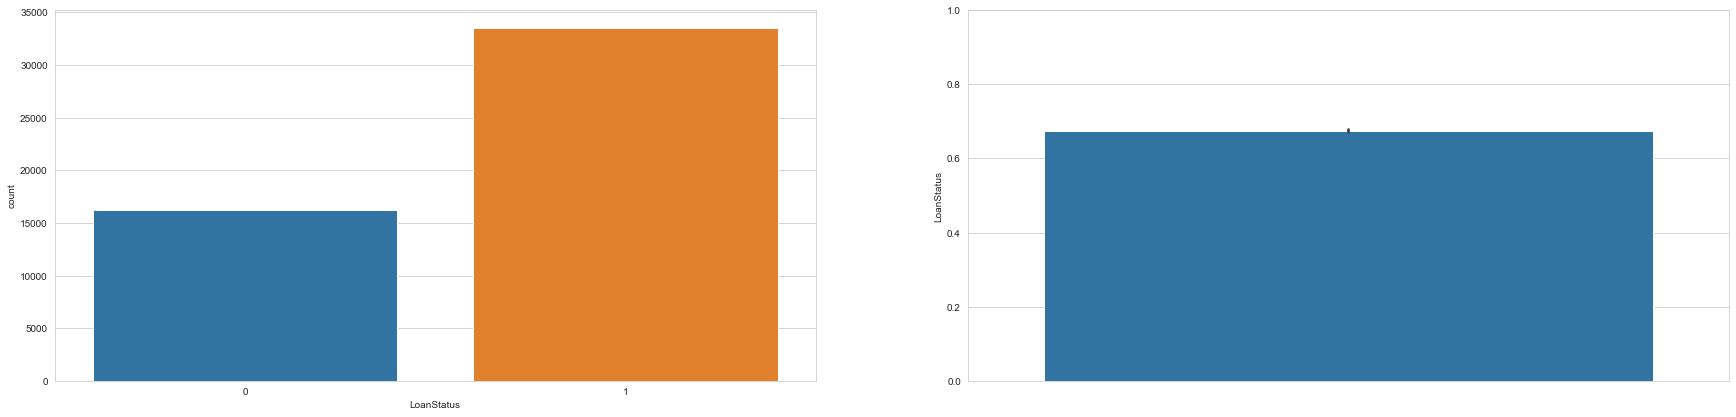

In [32]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.countplot(df_historical["LoanStatus"])

ax2 = fig.add_subplot(222)
sns.barplot(y=df_historical["LoanStatus"]).set_ylim([0,1])

In [33]:
df_historical["LoanStatus"].mean(), 1 - df_historical["LoanStatus"].mean()

(0.6743222588689567, 0.3256777411310433)

从历史数据整体来看，67.43%的贷款完成了。32.57%的贷款“违约”。

In [34]:
df_historical.describe()

,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,4.972400e+04,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.00000
mean,37.383316,0.674322,0.227630,0.203470,0.193209,0.171487,0.084773,0.099849,3.795129,6.098906,2.846553,81.636172,682.712171,701.712171,9.586819,8.366242,25.789578,6.411210,347.684177,1.798287,6.556894,0.643914,1066.158435,4.143170,0.311178,0.023369,1.569520e+04,0.532345,10765.711789,21.844542,0.857704,0.907047,5.390154,5122.985416,0.301364,4.558624,4.412779,0.134040,0.011705,1617.444157,543.321921,6527.303495,232.774829,0.998274,0.099228,0.051022,37.083268,109.01818
std,8.200240,0.468632,0.089797,0.082468,0.082052,0.079151,0.042269,0.058222,1.365905,1.759049,3.595906,85.135799,66.713278,66.713278,5.570450,4.980212,14.263379,4.454619,450.554180,2.739781,7.182246,2.000398,6717.698686,10.026401,0.744631,0.179542,3.380213e+04,0.349553,21926.061700,12.414067,0.172177,1.235013,47.175930,5695.264678,0.645141,11.410502,11.066557,1.105551,0.258911,4286.493397,1886.611584,5270.558892,186.245160,0.019836,0.476979,0.344454,443.751112,111.41890
min,12.000000,0.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,0.000000,0.000000,520.000000,539.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,0.700000,0.000000,0.000000,0.000000,1.00000
25%,36.000000,0.000000,0.153240,0.136400,0.125600,0.110200,0.072400,0.060300,3.000000,6.000000,1.000000,21.000000,640.000000,659.000000,6.000000,5.000000,15.000000,3.000000,78.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.647000e+03,0.220000,512.000000,13.000000,0.770000,0.000000,0.120000,2916.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3000.000000,106.990000,1.000000,0.000000,0.000000,0.000000,33.00000
50%,36.000000,1.000000,0.222370,0.199000,0.188000,0.160850,0.072400,0.102500,4.000000,6.000000,1.000000,53.000000,680.000000,699.000000,9.000000,8.000000,24.000000,6.000000,209.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.113500e+03,0.570000,3231.000000,20.000000,0.920000,1.000000,0.200000,4250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,173.710000,1.000000,0.000000,0.000000,0.000000,73.00000
75%,36.000000,1.000000,0.305130,0.270000,0.259900,0.236

### 探索性数据分析：分类数据

1) BorrowerState - 债务人所在州

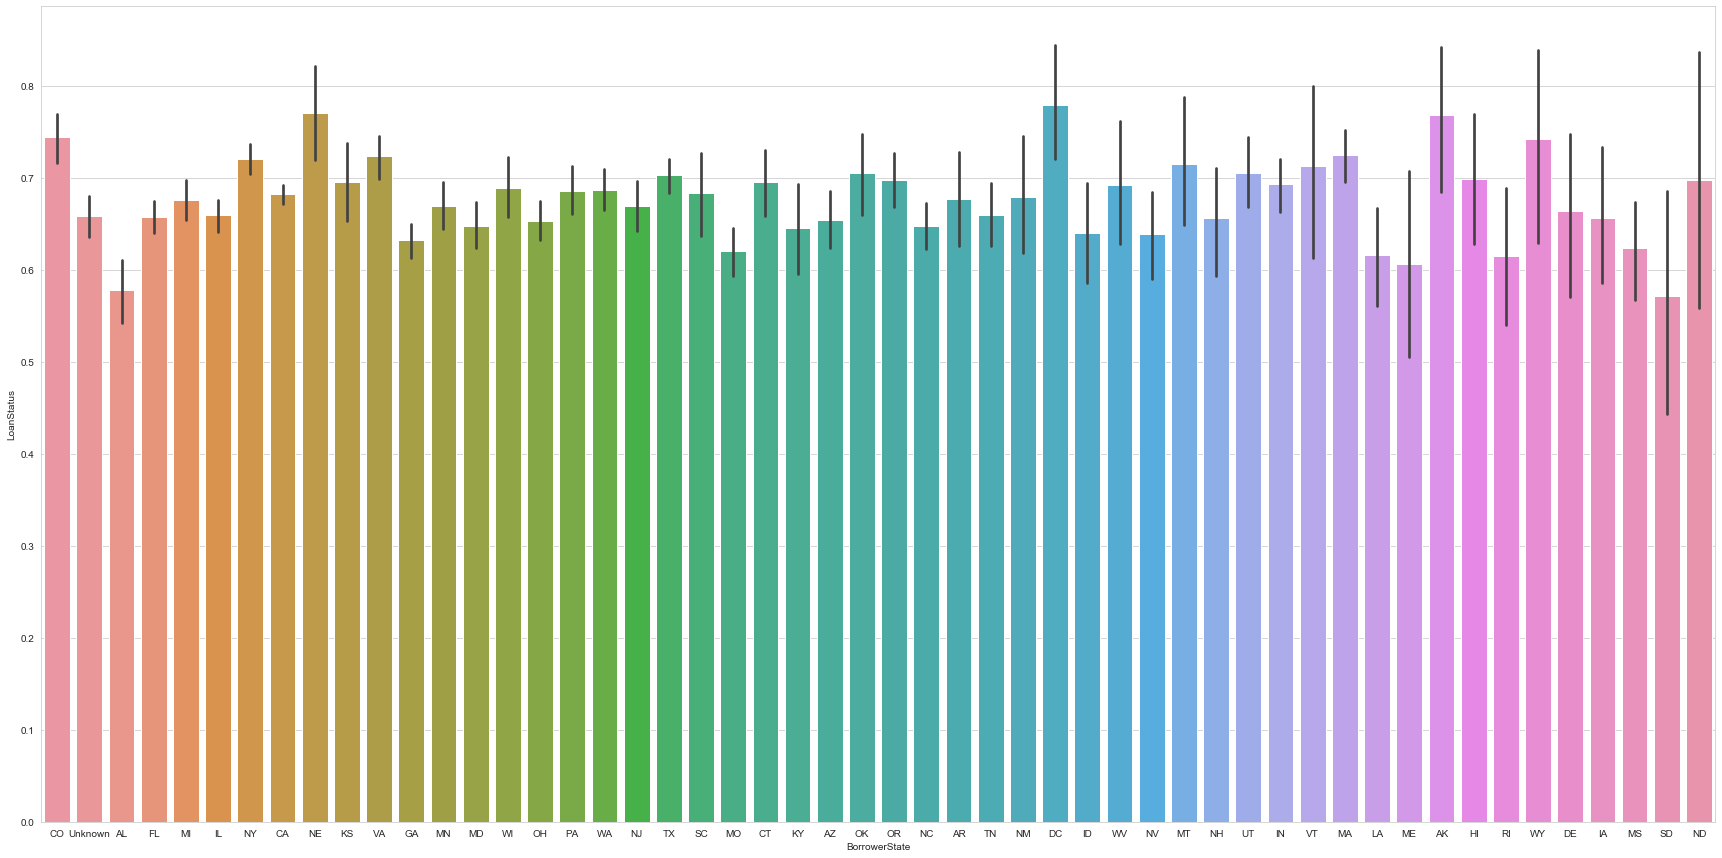

In [35]:
sns.barplot(x="BorrowerState", y="LoanStatus", data=df_historical)

In [36]:
al, dc = df_historical[df_historical["BorrowerState"] == "AL"], df_historical[df_historical["BorrowerState"] == "DC"]

1 - al["LoanStatus"].mean(), 1 - dc["LoanStatus"].mean()

(0.42205323193916355, 0.22043010752688175)

各个州居民之间似乎存在差异。阿拉巴马州(AL)贷款的违约率为42.21%，而华盛顿特区(DC)贷款的违约率仅为22.04%。这一变量可能可用作分类器，但得要转换成dummy变量。

2) ListingCategory - 贷款用途

In [37]:
df_historical.replace(to_replace={"ListingCategory (numeric)": {0: "Unknown", 1: "Debt", 2: "Reno", 3: "Business", 4: "Personal",
                                                                5: "Student", 6: "Auto", 7: "Other", 8: "Baby", 9: "Boat", 
                                                                10: "Cosmetic", 11: "Engagement", 12: "Green", 13: "Household",
                                                                14: "LargePurchase", 15: "Medical", 16: "Motorcycle", 17: "RV",
                                                                18: "Taxes", 19: "Vacation", 20: "Wedding"}}, inplace=True)

df_historical.rename(index=str, columns={"ListingCategory (numeric)": "ListingCategory"}, inplace=True)

df_historical["ListingCategory"][:10]

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:6702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,
D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


0       Unknown
11      Unknown
12         Debt
15    Household
21      Unknown
23      Medical
26         Debt
27         Debt
30      Wedding
33        Other
Name: ListingCategory, dtype: object

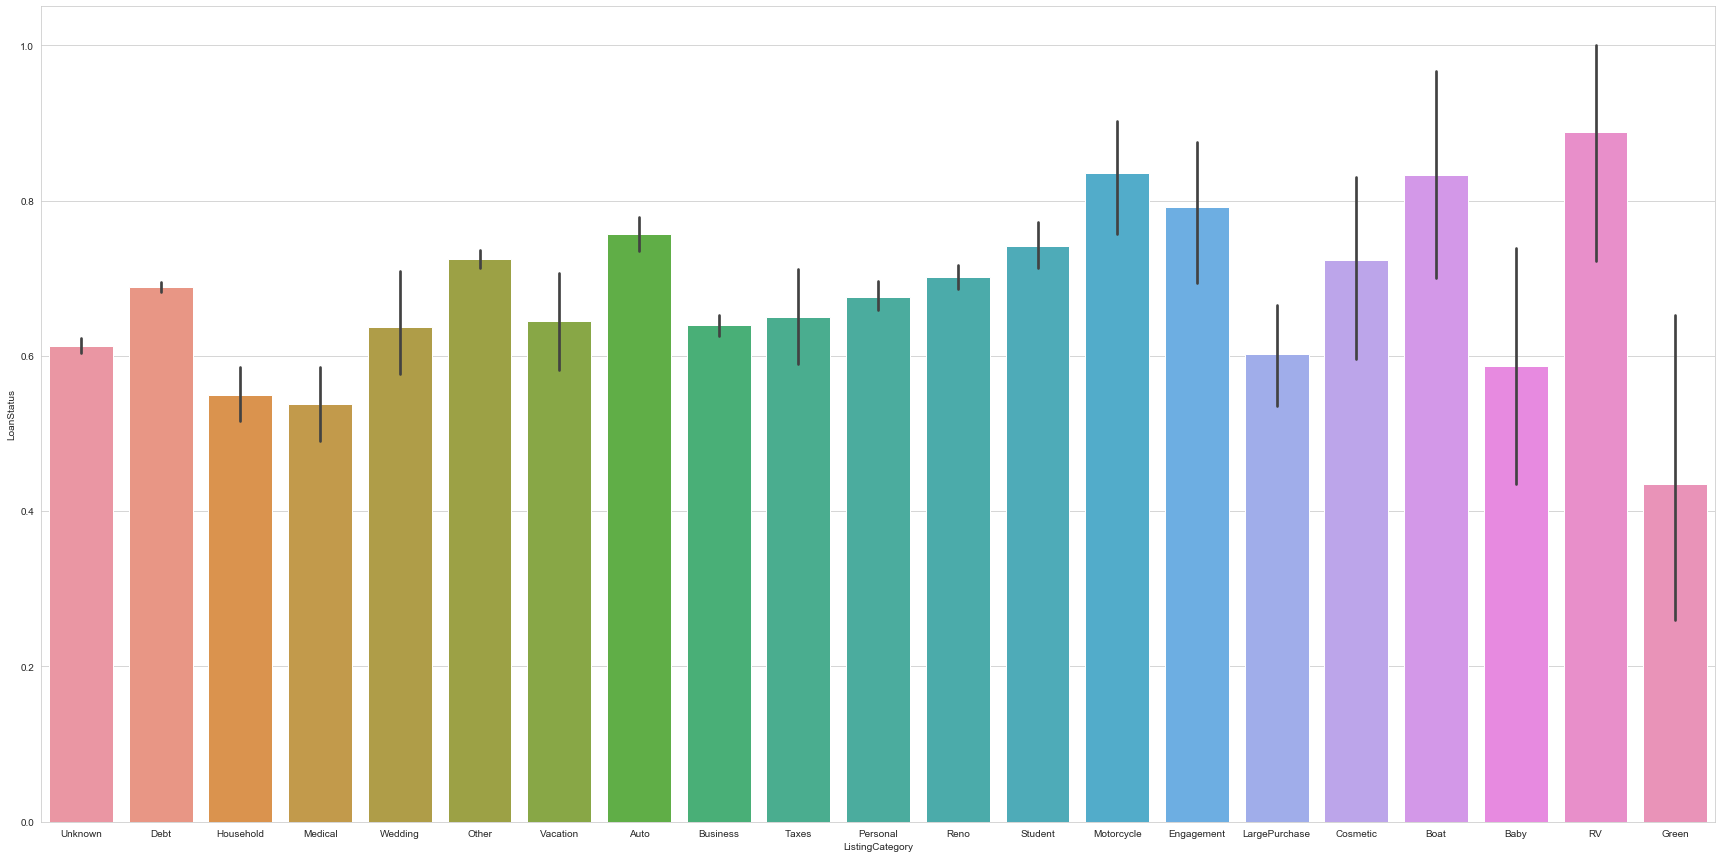

In [38]:
sns.barplot(x="ListingCategory", y="LoanStatus", data=df_historical)

In [39]:
rv, green = df_historical[df_historical["ListingCategory"] == "RV"], df_historical[df_historical["ListingCategory"] == "Green"]

1 - rv["LoanStatus"].mean(), 1 - green["LoanStatus"].mean()

(0.11111111111111116, 0.5652173913043479)

某些用途的贷款偿付表现似乎优于其他用途，房车贷款违约率仅为11.11%，Green贷款(并不知道干什么的)违约率为56.52%。其他经常拖欠贷款的是家庭开支贷款(Household)和医疗贷款(Medical)，而用于购买船只(Boat)和用于偿还其他债务(Debt)的贷款都有较低的违约率。

### 探索性数据分析：信用评分

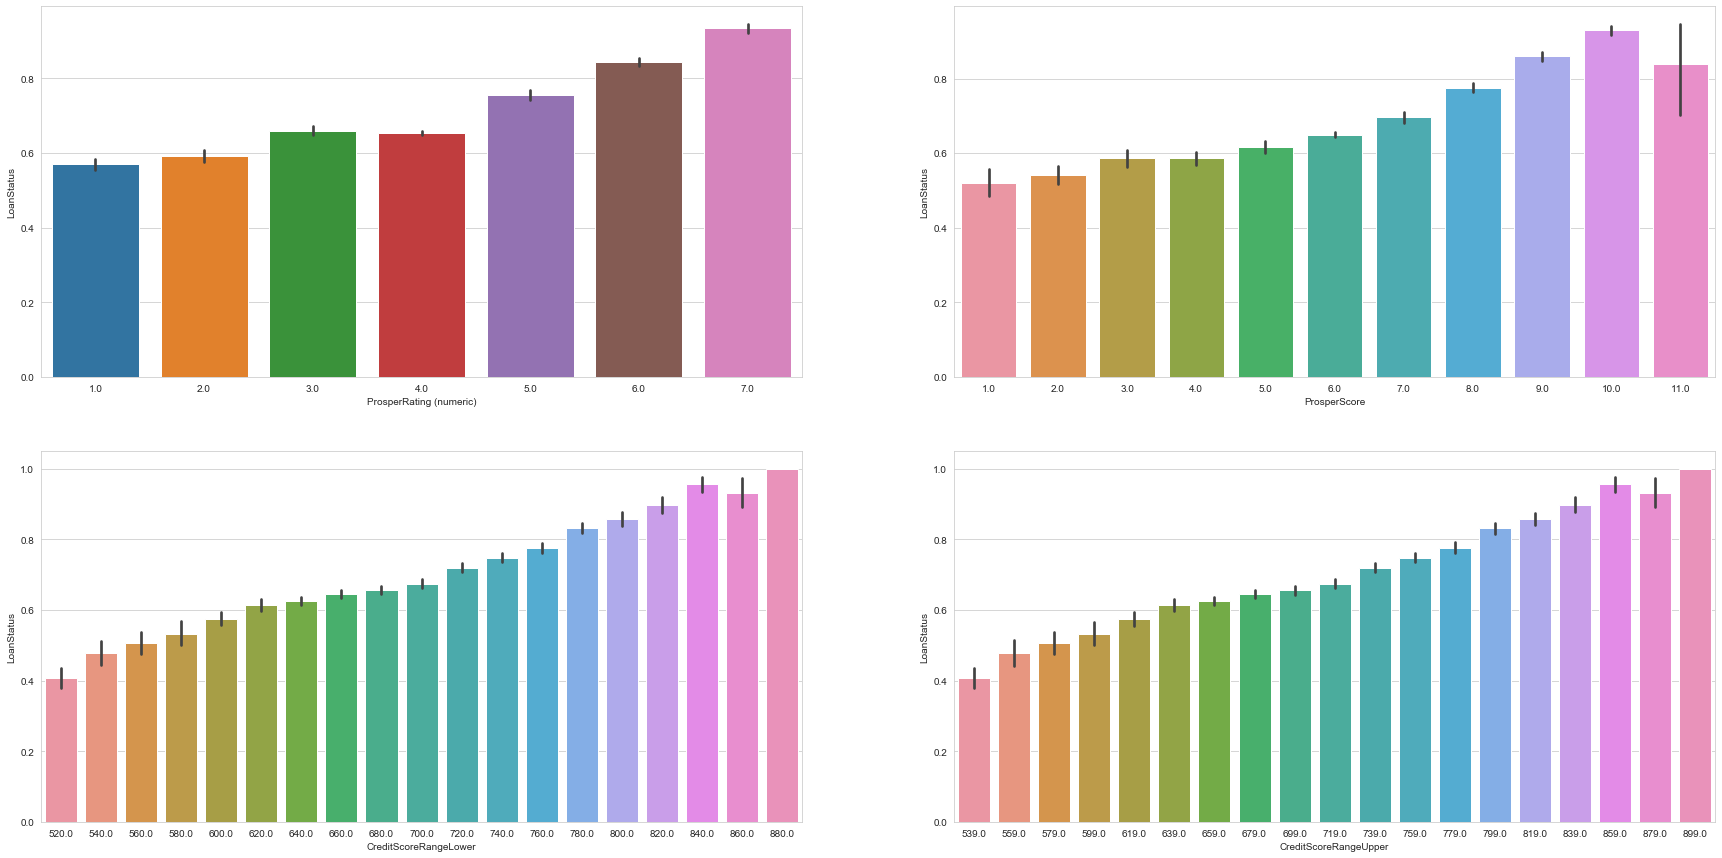

In [40]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="ProsperRating (numeric)", y="LoanStatus", data=df_historical)

ax2 = fig.add_subplot(222)
sns.barplot(x="ProsperScore", y="LoanStatus", data=df_historical)

ax3 = fig.add_subplot(223)
sns.barplot(x="CreditScoreRangeLower", y="LoanStatus", data=df_historical)

ax4 = fig.add_subplot(224)
sns.barplot(x="CreditScoreRangeUpper", y="LoanStatus", data=df_historical)

Prosper Rating和Prosper Score似乎都能很好地预测违约，评级越高违约的频率越低。值得注意的是，拥有信用评级11的贷款比评级为9或10的贷款违约地更频繁，但这并不反对前面的结论，因为评级11本身的定义也不太清楚，变量解释中并没有提及评级11: "Prosper Score - A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. Applicable for loans originated after July 2009."。变量解释中Prosper Score是只有10个评级的，那评级11是什么意思就是个迷了。

后两幅图描述信用评分(Credit Score)的上下限。这里，Credit Score的“范围”似乎是恒定的，即Lower到Upper的值是常数。所以我们可以去掉冗余，去掉CreditScoreRangeUpper，将下限重命名为“CreditScore”。

In [41]:
credit_score_range = df_historical["CreditScoreRangeUpper"] - df_historical["CreditScoreRangeLower"]

credit_score_range.value_counts()

19.0    49724
dtype: int64

In [42]:
df_historical.drop("CreditScoreRangeUpper", axis=1, inplace=True)

df_historical.rename(index=str, columns={"CreditScoreRangeLower": "CreditScore"}, inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 探索性数据分析：财务背景信息

(0, 400)

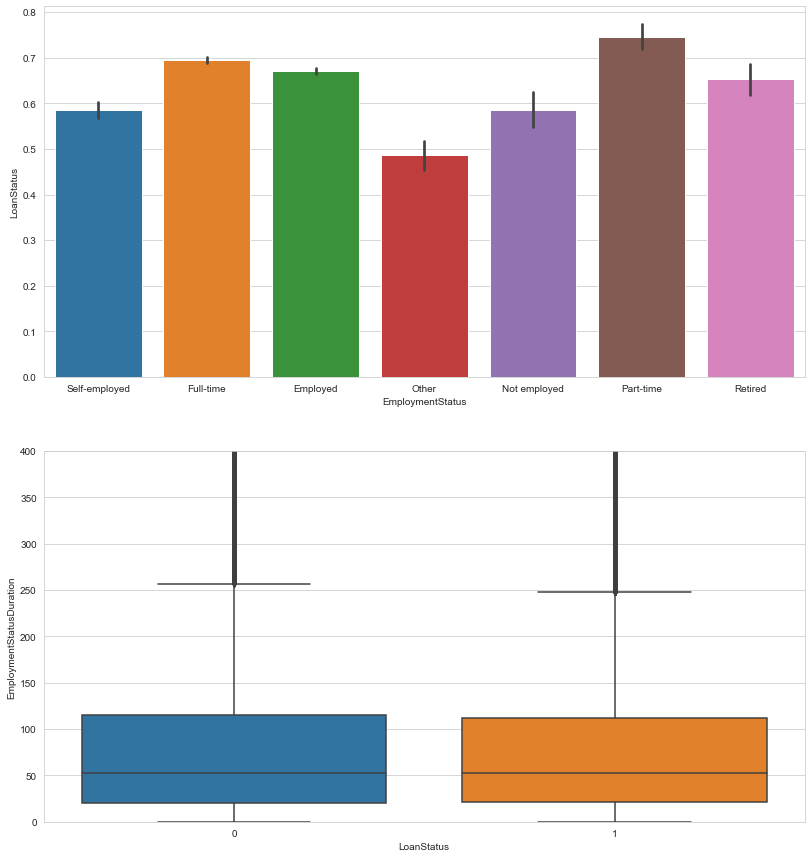

In [43]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="EmploymentStatus", y="LoanStatus", data=df_historical)

ax2 = fig.add_subplot(223)
sns.boxplot(x="LoanStatus", y="EmploymentStatusDuration", data=df_historical).set_ylim([0,400])

债务人的就业状况似乎与违约行为有关系。这里有几个有趣的点，做兼职的人的违约率比全职的人要低，选择“其他”的人比那些完全没有工作的人更可能违约，而自由职业者和没有工作的人表现差不多。另一方面，就业状况的持续时间似乎与违约行为没有关系，但我们现在还得再进一步验证。

In [44]:
x = df_historical["EmploymentStatusDuration"]
y = df_historical["LoanStatus"]

r, p = st.pearsonr(x, y)

print("The correlation between employment status duration and loan default is {}, with a p-value of {}".format(r, p))

The correlation between employment status duration and loan default is -0.005905702858997275, with a p-value of 0.18787754222074204


就业状况得持续时间和贷款违约之间的相关性非常弱，而且在统计上p值不显著，所以我们可以将这个变量从数据集中删除。

In [45]:
df_historical.drop("EmploymentStatusDuration", axis=1, inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


接下来我们来看下收入和信贷的影响。

(0, 0.8)

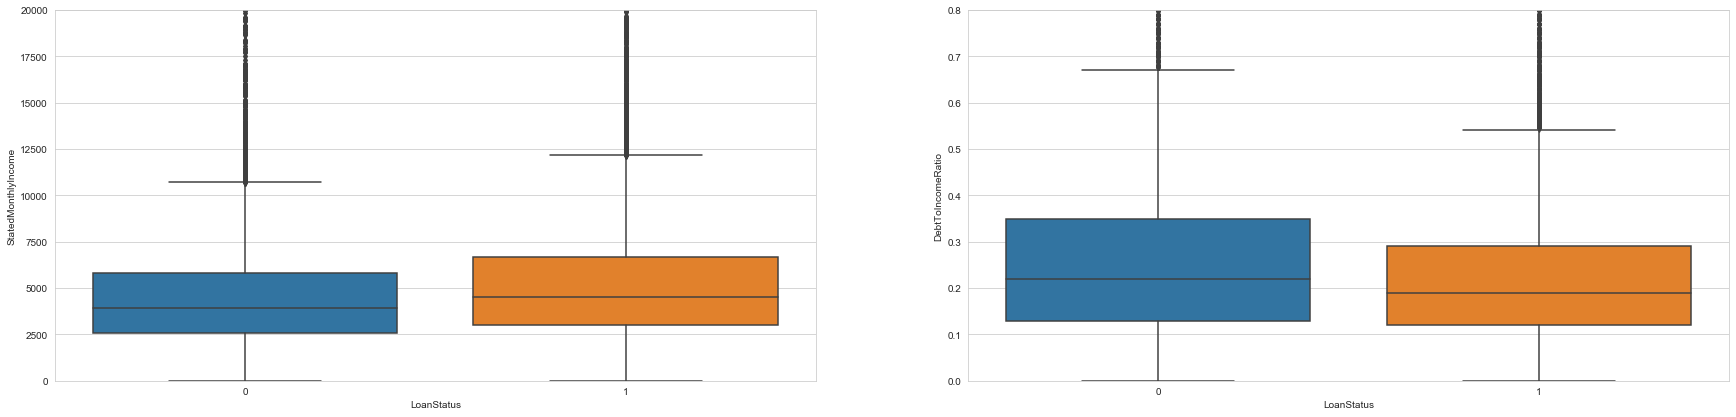

In [46]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="StatedMonthlyIncome", data=df_historical).set_ylim([0,20000])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="DebtToIncomeRatio", data=df_historical).set_ylim([0,0.8])

债务人的收入似乎与违约行为有关系。收入较高的人拖欠贷款的可能性都比收入较低的人要低，不过这里我们并没有考虑到贷款规模大小所带来的影响。另一方面，如果债务与收入之比越高，贷款越有可能违约，这一结论比较符合直觉。

(0, 2.5)

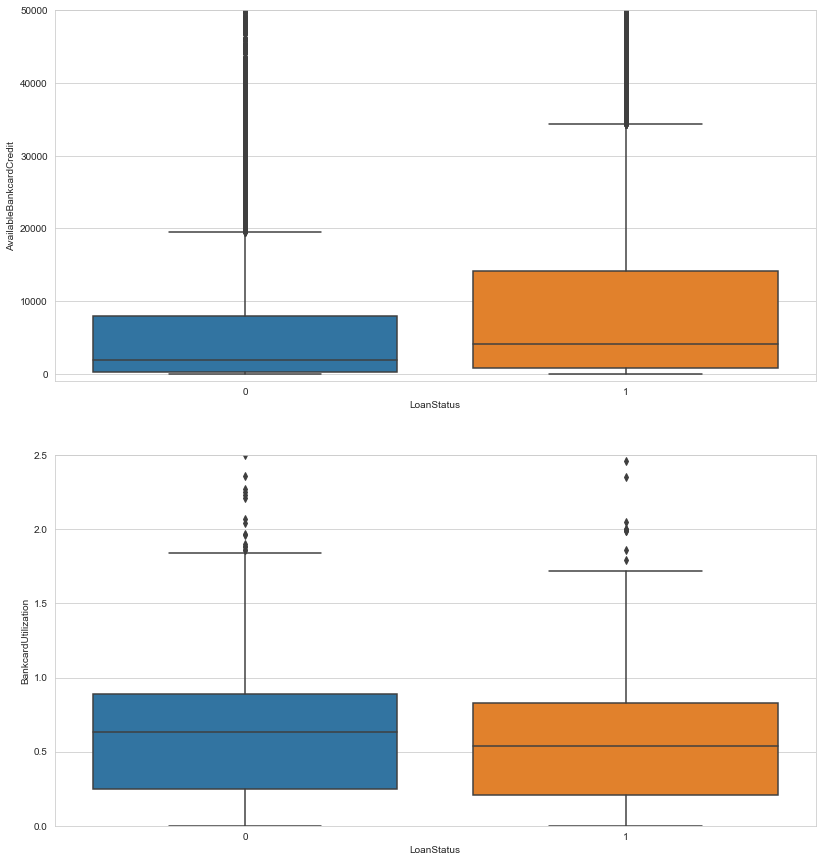

In [47]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="AvailableBankcardCredit", data=df_historical).set_ylim([-1000, 50000])

ax2 = fig.add_subplot(223)
sns.boxplot(x="LoanStatus", y="BankcardUtilization", data=df_historical).set_ylim([0,2.5])

在看下信用数据，信用卡可使用的额度似乎与贷款违约有关，额度越高的债务人准时还款的概率越大。不过，信用卡的利用比例的情况相反，大比例使用信用卡的债务人更可能违约。

(0, 1)

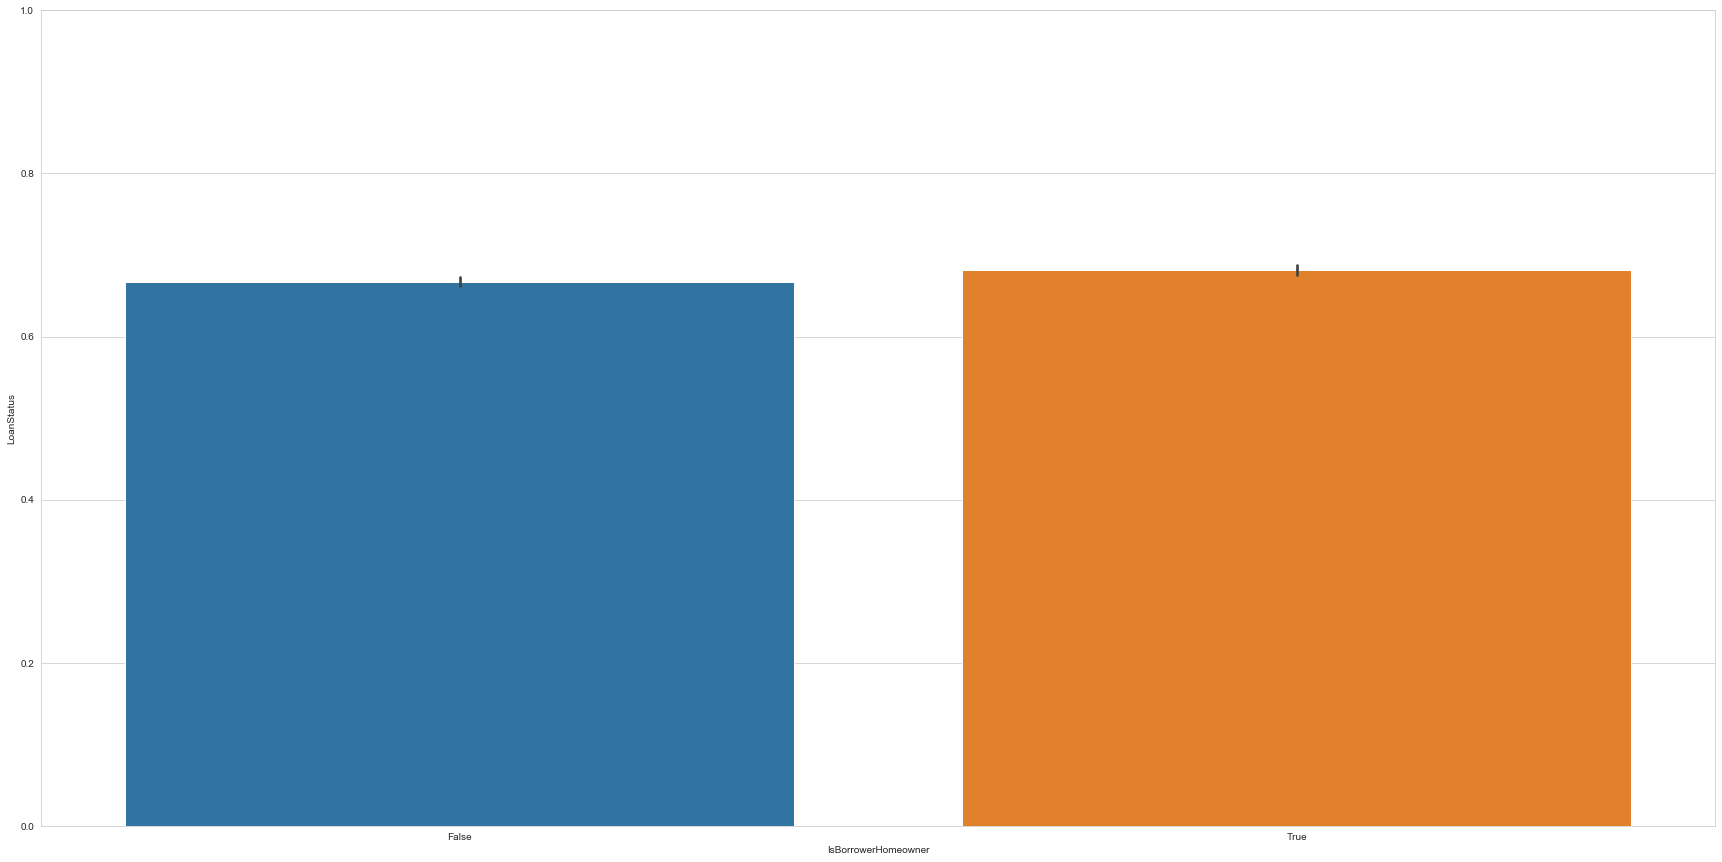

In [48]:
sns.barplot(x="IsBorrowerHomeowner", y="LoanStatus", data=df_historical).set_ylim([0,1])

房产对借贷行为的影响似乎不大，持有房产的人的违约率比无房者稍微低了一点。

下一步，我们考量债务人征信历史的影响。

### 探索性数据分析：征信历史

(0, 20)

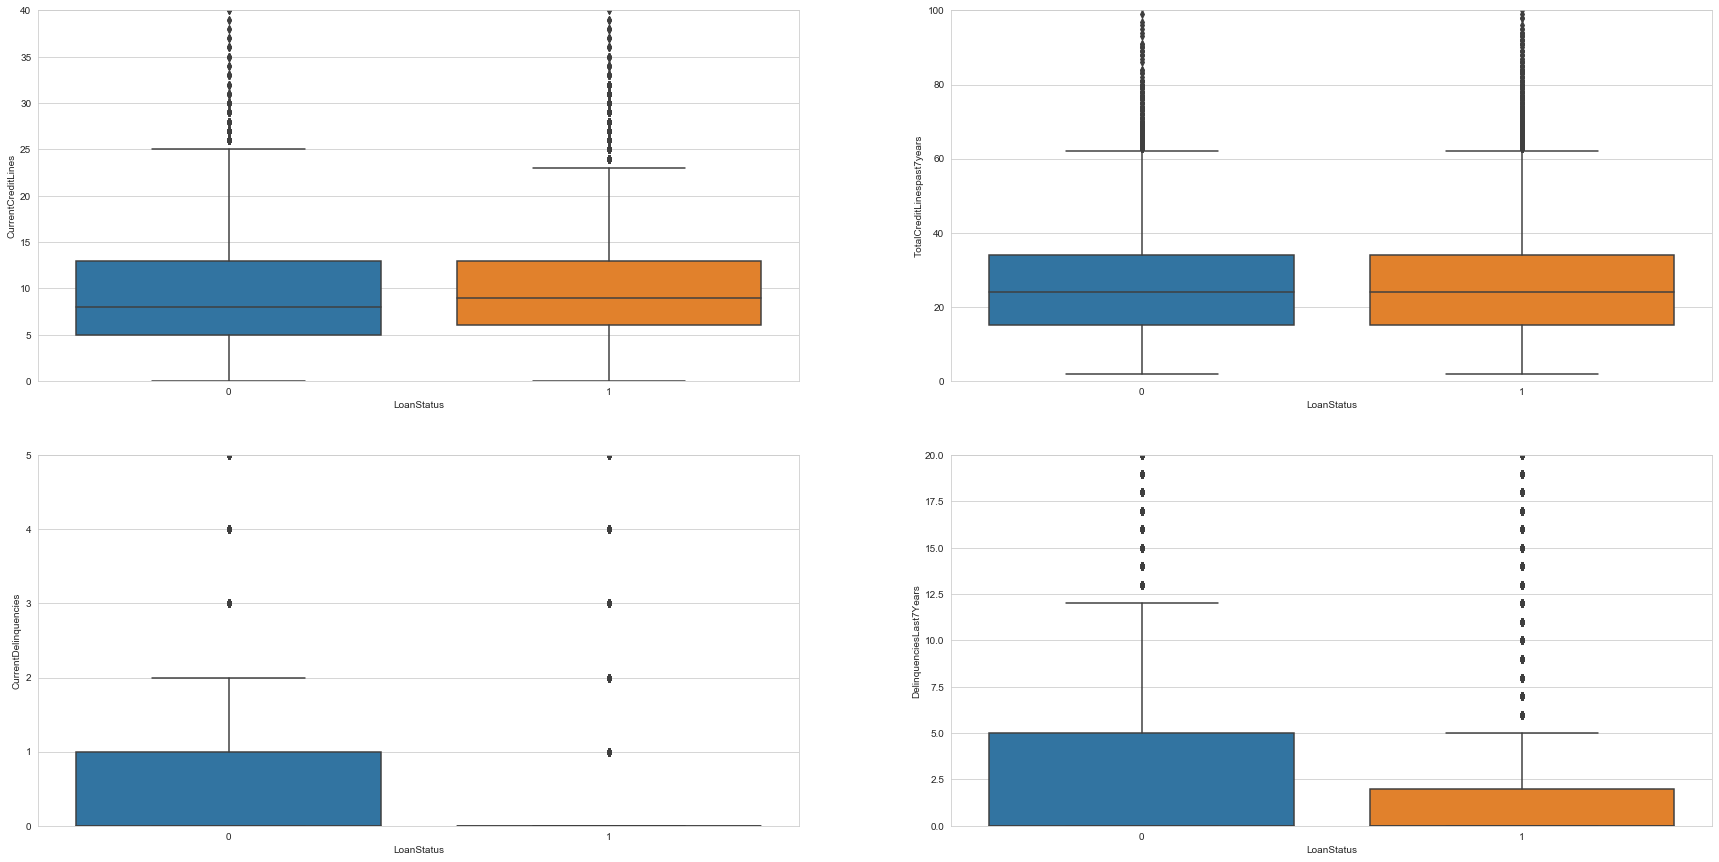

In [49]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="CurrentCreditLines", data=df_historical).set_ylim([0,40])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="TotalCreditLinespast7years", data=df_historical).set_ylim([0,100])

ax3 = fig.add_subplot(223)
sns.boxplot(x="LoanStatus", y="CurrentDelinquencies", data=df_historical).set_ylim([0,5])

ax4 = fig.add_subplot(224)
sns.boxplot(x="LoanStatus", y="DelinquenciesLast7Years", data=df_historical).set_ylim([0,20])

信用额度似乎与违约没有什么关系，但与拖欠行为有关系。按时偿还贷款的债务人很少有存在拖欠其他贷款的情况。同时，有拖欠债款的人有更多的违约倾向。

In [50]:
delinquency = ["CurrentDelinquencies", "DelinquenciesLast7Years"]
y = df_historical["LoanStatus"]

for var in delinquency:
    x = df_historical[var]
    r, p = st.pearsonr(x, y)

    print("The correlation between {} and loan default is {}, with a p-value of {}".format(var, r, p))

The correlation between CurrentDelinquencies and loan default is -0.12107063477741718, with a p-value of 1.084524265191807e-161
The correlation between DelinquenciesLast7Years and loan default is -0.06975250066577975, with a p-value of 1.1176410321407398e-54


当前与历史拖欠款项都与违约行为有关，且p值十分显著。这可能是一个非常明显的特征。

### 探索性数据分析：贷款产品自身特征

(10, 60)

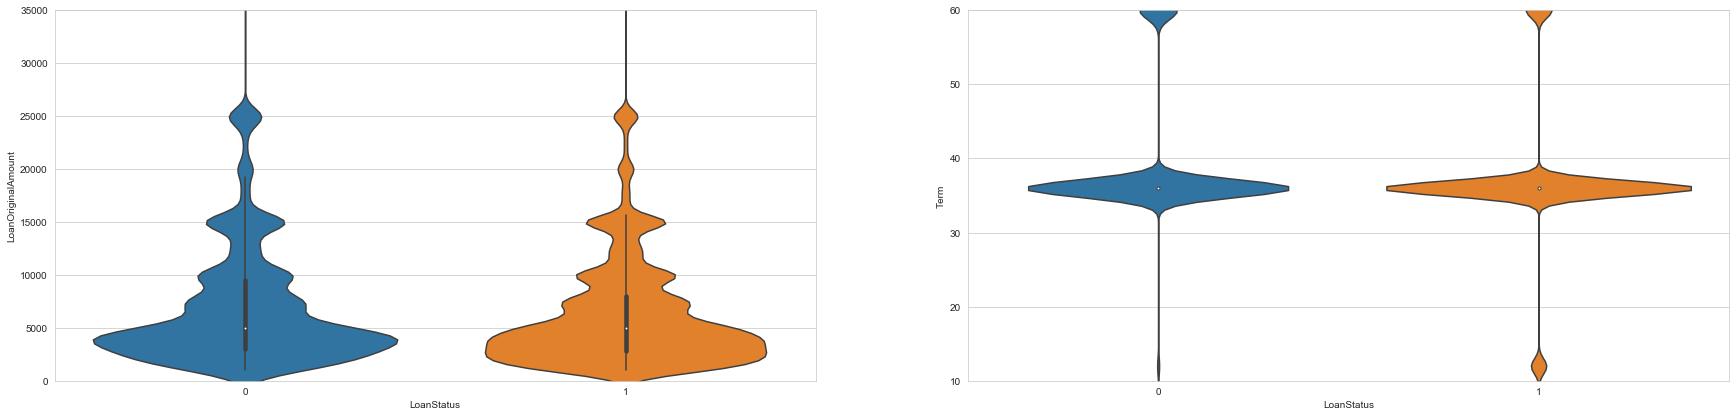

In [51]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.violinplot(x="LoanStatus", y="LoanOriginalAmount", data=df_historical).set_ylim([0,35000])

ax2 = fig.add_subplot(222)
sns.violinplot(x="LoanStatus", y="Term", data=df_historical).set_ylim([10, 60])

两种状态的贷款额度分布十分相似。同时该平台的贷款期限似乎比较固定，只有那么几个期限选择。

In [52]:
df_historical["Term"].value_counts()

36    43754
60     4418
12     1552
Name: Term, dtype: int64

具体来看，这个平台提供的的贷款期限只有12个月、36个月或60个月。从图中可以看出，最常见的期限是3年，而且占比超过九成。这也意味着贷款期限这一变量对我们这次分析帮助不大。

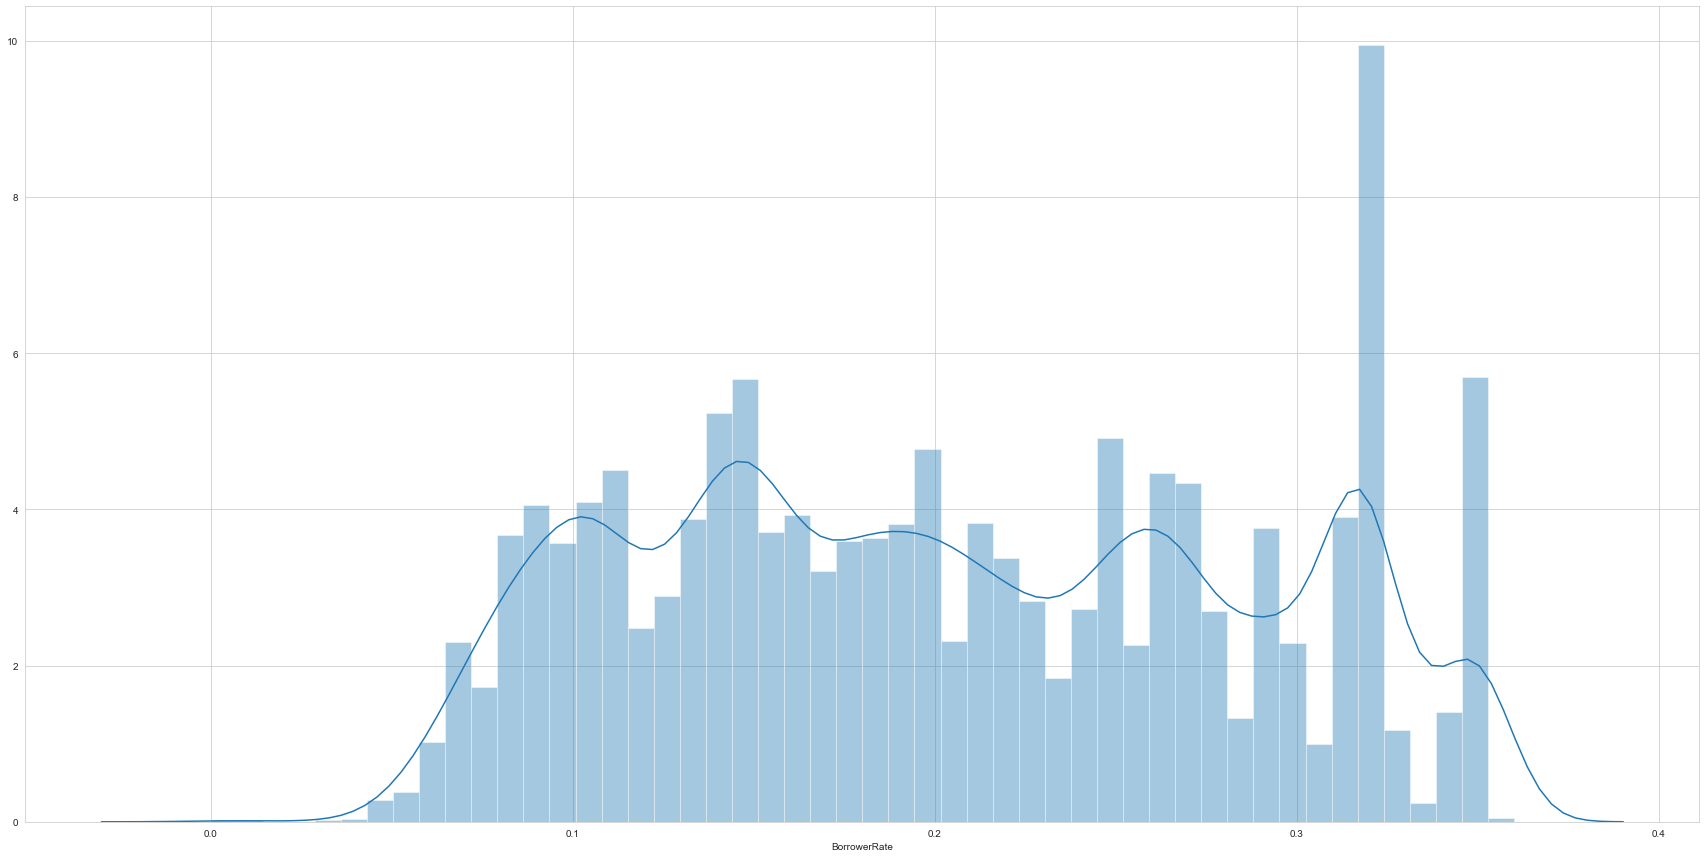

In [53]:
sns.distplot(df_historical["BorrowerRate"])

In [54]:
df_historical["BorrowerRate"].describe()

count    49724.000000
mean         0.203470
std          0.082468
min          0.000000
25%          0.136400
50%          0.199000
75%          0.270000
max          0.360000
Name: BorrowerRate, dtype: float64

贷款的利率的均值是20.35%左右，而且标准偏差有8.25%，同时最低的25%的借款人支付的利息为13.64%，这利率还算过得去。但最高的25%的借款人支付的利息为27.00%甚至更多。

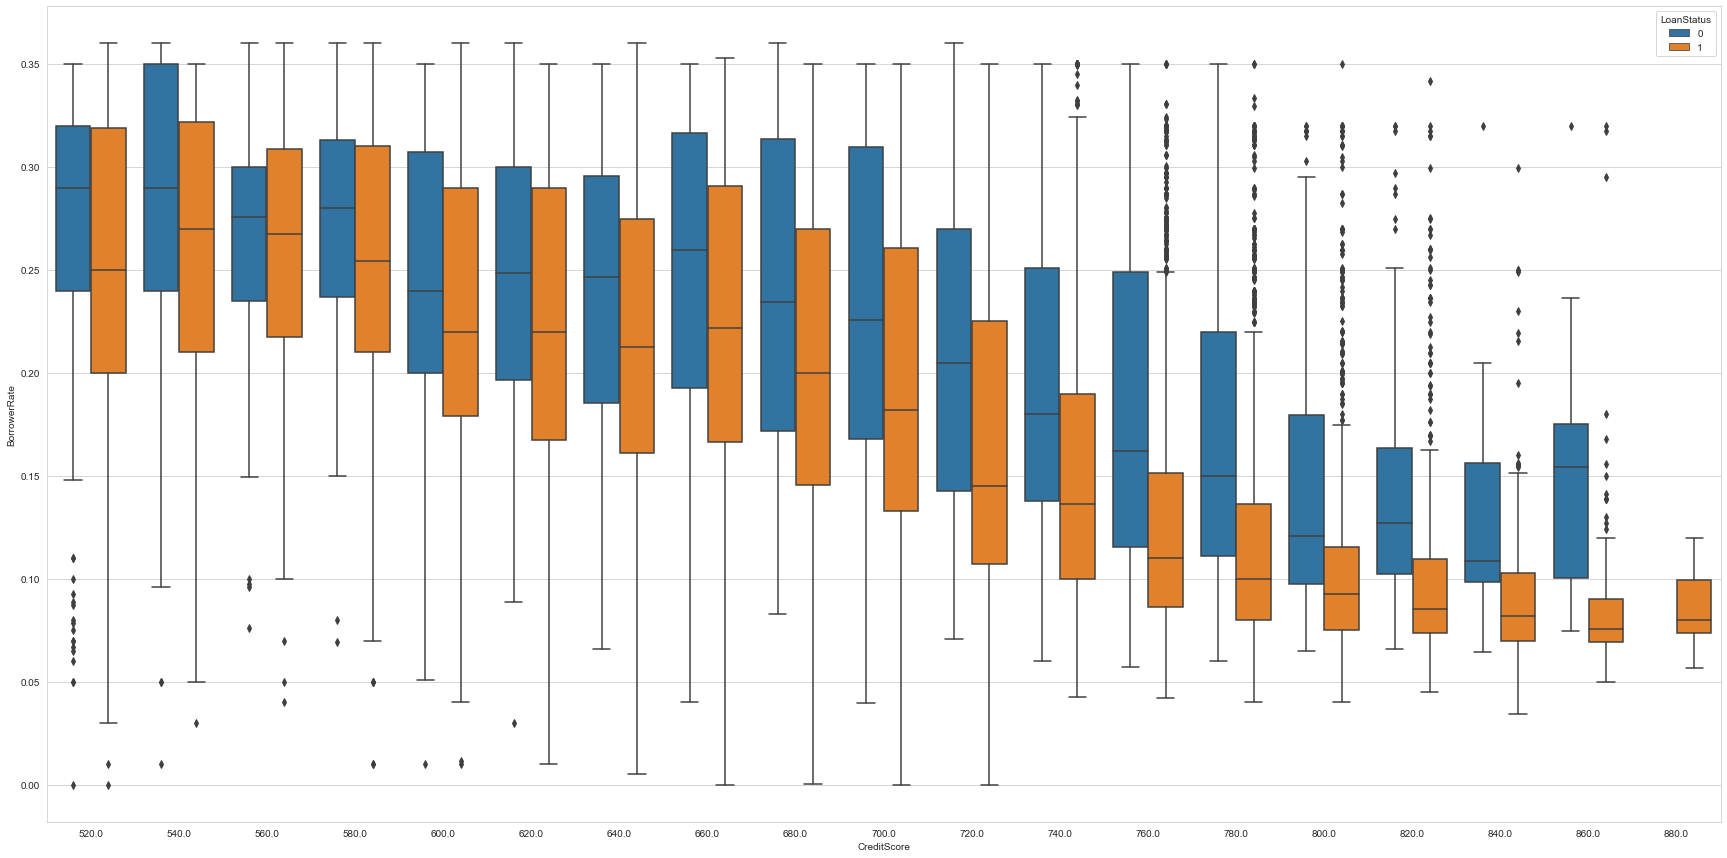

In [55]:
sns.boxplot(x="CreditScore", y='BorrowerRate', hue='LoanStatus', data=df_historical)

即使在控制信用评分的情况下，违约贷款的利率也比完全偿还的贷款要高。高出来的这一部分算是风险溢价了。

综上，我们希望能借助这些相关性比较强的特征建立数据模型。

### 降维：删除多余的列

In [56]:
df_historical.describe()

,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,CreditScore,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,4.972400e+04,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.00000
mean,37.383316,0.674322,0.227630,0.203470,0.193209,0.171487,0.084773,0.099849,3.795129,6.098906,682.712171,9.586819,8.366242,25.789578,6.411210,347.684177,1.798287,6.556894,0.643914,1066.158435,4.143170,0.311178,0.023369,1.569520e+04,0.532345,10765.711789,21.844542,0.857704,0.907047,5.390154,5122.985416,0.301364,4.558624,4.412779,0.134040,0.011705,1617.444157,543.321921,6527.303495,232.774829,0.998274,0.099228,0.051022,37.083268,109.01818
std,8.200240,0.468632,0.089797,0.082468,0.082052,0.079151,0.042269,0.058222,1.365905,1.759049,66.713278,5.570450,4.980212,14.263379,4.454619,450.554180,2.739781,7.182246,2.000398,6717.698686,10.026401,0.744631,0.179542,3.380213e+04,0.349553,21926.061700,12.414067,0.172177,1.235013,47.175930,5695.264678,0.645141,11.410502,11.066557,1.105551,0.258911,4286.493397,1886.611584,5270.558892,186.245160,0.019836,0.476979,0.344454,443.751112,111.41890
min,12.000000,0.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,520.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,0.700000,0.000000,0.000000,0.000000,1.00000
25%,36.000000,0.000000,0.153240,0.136400,0.125600,0.110200,0.072400,0.060300,3.000000,6.000000,640.000000,6.000000,5.000000,15.000000,3.000000,78.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.647000e+03,0.220000,512.000000,13.000000,0.770000,0.000000,0.120000,2916.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3000.000000,106.990000,1.000000,0.000000,0.000000,0.000000,33.00000
50%,36.000000,1.000000,0.222370,0.199000,0.188000,0.160850,0.072400,0.102500,4.000000,6.000000,680.000000,9.000000,8.000000,24.000000,6.000000,209.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.113500e+03,0.570000,3231.000000,20.000000,0.920000,1.000000,0.200000,4250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,173.710000,1.000000,0.000000,0.000000,0.000000,73.00000
75%,36.000000,1.000000,0.305130,0.270000,0.259900,0.236400,0.100000,0.136300,4.000000,7.000000,720.000000,13.000000,11.000000,34.000000,9.000000,447.000000,2.000000,8.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.619825e+04,0.850000,11950.000000,29.000000,1.000000,1.000000,0.310000,6250.000000,0.000000,0.000000,0.00

In [57]:
df_historical.drop(["CreditGrade", "BorrowerAPR", "LenderYield", "EstimatedEffectiveYield", "EstimatedLoss", "EstimatedReturn",
                 "ProsperRating (Alpha)", "Occupation", "CurrentlyInGroup", "GroupKey", "IncomeRange", "PercentFunded"], axis=1,
                inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 45 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int32
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
ListingCategory                        49724 non-null object
BorrowerState                          49724 non-null object
EmploymentStatus                       49724 non-null object
IsBorrowerHomeowner                    49724 non-null bool
CreditScore                            49724 non-null float64
FirstRecordedCreditLine                49724 non-null object
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                 

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 预处理：调整数据类型

这一步我们要将所有的 bool 类型改成 int(0和1)。

In [58]:
df_historical["IsBorrowerHomeowner"] = df_historical["IsBorrowerHomeowner"].astype(int)
df_historical["IncomeVerifiable"] = df_historical["IncomeVerifiable"].astype(int)

df_historical["IsBorrowerHomeowner"][:10], df_historical["IncomeVerifiable"][:10]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0     1
 11    0
 12    0
 15    1
 21    0
 23    0
 26    0
 27    1
 30    0
 33    0
 Name: IsBorrowerHomeowner, dtype: int32, 0     1
 11    1
 12    1
 15    1
 21    1
 23    1
 26    1
 27    1
 30    1
 33    1
 Name: IncomeVerifiable, dtype: int32)

除此之外，还有4个object类型数据需要处理。先看下FirstRecordedCreditLine，估计是个datetime。

In [59]:
df_historical["FirstRecordedCreditLine"][:10]

0     2001-10-11 00:00:00
11    2000-11-13 00:00:00
12    1996-11-09 00:00:00
15    1999-03-08 00:00:00
21    2003-06-20 00:00:00
23    1998-06-09 00:00:00
26    1975-10-26 00:00:00
27    2000-04-11 00:00:00
30    1988-06-01 00:00:00
33    2003-12-01 00:00:00
Name: FirstRecordedCreditLine, dtype: object

FirstRecordedCreditLine是第一个开通信用额度的日期，我们可以将它转换为已开通的年份（一个连续的int）。这里用2014年为基准。

In [60]:
first_credit_year = df_historical["FirstRecordedCreditLine"].str[:4]

df_historical["YearsWithCredit"] = 2014 - pd.to_numeric(first_credit_year)

df_historical.drop("FirstRecordedCreditLine", axis=1, inplace=True)

df_historical["YearsWithCredit"][:10]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0     13
11    14
12    18
15    15
21    11
23    16
26    39
27    14
30    26
33    11
Name: YearsWithCredit, dtype: int64

剩下要做的就是把ListingCategory、BorrowerState、EmploymentStatus转换成dummy变量。

In [61]:
category = pd.get_dummies(df_historical["ListingCategory"])

df_historical = df_historical.join(category, rsuffix="_category")
df_historical.drop("ListingCategory", axis=1, inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 65 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int32
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
BorrowerState                          49724 non-null object
EmploymentStatus                       49724 non-null object
IsBorrowerHomeowner                    49724 non-null int32
CreditScore                            49724 non-null float64
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                  49724 non-null int64
OpenRevolvingMonthlyPayment            49724 non-null float64
InquiriesLast6Months                 

In [62]:
employment = pd.get_dummies(df_historical["EmploymentStatus"])

df_historical = df_historical.join(employment, rsuffix="_employmentstatus")
df_historical.drop("EmploymentStatus", axis=1, inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 71 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int32
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
BorrowerState                          49724 non-null object
IsBorrowerHomeowner                    49724 non-null int32
CreditScore                            49724 non-null float64
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                  49724 non-null int64
OpenRevolvingMonthlyPayment            49724 non-null float64
InquiriesLast6Months                   49724 non-null float64
TotalInquiries                      

In [63]:
state_defaults = df_historical.groupby("BorrowerState")["LoanStatus"].mean()

vlow_risk = sorted(state_defaults)[51]
low_risk = sorted(state_defaults)[40]
mid_risk = sorted(state_defaults)[29]
high_risk = sorted(state_defaults)[19]
vhigh_risk = sorted(state_defaults)[9]

new_geography = {}

for state in state_defaults.index:
    if high_risk > state_defaults[state]:
        v = "StateVeryHighRisk"
    elif mid_risk > state_defaults[state] >= high_risk:
        v = "StateHighRisk"
    elif low_risk > state_defaults[state] >= mid_risk:
        v = "StateMidRisk"
    elif vlow_risk > state_defaults[state] >= low_risk:
        v = "StateLowRisk"
    else:
        v = "StateVeryLowRisk"
    new_geography[state] = v

df_historical.replace(to_replace={"BorrowerState": new_geography}, inplace=True)
                               
df_historical["BorrowerState"][:10]

0          StateLowRisk
11    StateVeryHighRisk
12    StateVeryHighRisk
15    StateVeryHighRisk
21        StateHighRisk
23        StateHighRisk
26         StateLowRisk
27         StateLowRisk
30        StateHighRisk
33        StateHighRisk
Name: BorrowerState, dtype: object

这里因为52个州实在太多了，我们只能先将其分类，在转换成dummy。

In [64]:
state = pd.get_dummies(df_historical["BorrowerState"])

df_historical = df_historical.join(state, rsuffix="_state")
df_historical.drop("BorrowerState", axis=1, inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 75 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int32
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
IsBorrowerHomeowner                    49724 non-null int32
CreditScore                            49724 non-null float64
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                  49724 non-null int64
OpenRevolvingMonthlyPayment            49724 non-null float64
InquiriesLast6Months                   49724 non-null float64
TotalInquiries                         49724 non-null float64
CurrentDelinquencies               

### 训练集与测试集划分

In [65]:
X = df_historical.drop("LoanStatus", axis=1)
y = df_historical["LoanStatus"]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 预处理:缩放特征

In [67]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 降维：主成分分析、单变量特征选择

用主成分分析和单变量特征选择进行降维，随后会对比这些降维方法能不能提升模型表现。

In [68]:
pca = PCA(n_components=10)
pca.fit(X_train_scaled)

X_train_pca10 = pca.transform(X_train_scaled)
X_test_pca10 = pca.transform(X_test_scaled)

pca.explained_variance_ratio_

array([0.17670123, 0.11838247, 0.09699779, 0.08818248, 0.07777252,
       0.05738194, 0.05187247, 0.04803878, 0.04100432, 0.0337039 ])

In [69]:
pca = PCA(n_components=3)
pca.fit(X_train)

X_train_pca3 = pca.transform(X_train_scaled)
X_test_pca3 = pca.transform(X_test_scaled)

pca.explained_variance_ratio_

array([0.68228994, 0.24762512, 0.02503526])

In [70]:
X_train_reduce50 = SelectPercentile(percentile=50).fit_transform(X_train_scaled, y_train)
X_test_reduce50 = SelectPercentile(percentile=50).fit_transform(X_test_scaled, y_test)

X_train_reduce10 = SelectPercentile().fit_transform(X_train_scaled, y_train)
X_test_reduce10 = SelectPercentile().fit_transform(X_test_scaled, y_test)

### 分类器的选择

一般来说，我们会想要尽可能地预测哪些贷款会违约、哪些不会。但是在借出资金的债权人的角度看，我们更希望尽量减少会违约的借贷。我们的真正目标是正确地分类尽可能多的违约贷款，这也意味着可能会“错怪”一些本来能偿还债务的用户。因此，我们要做的是最大化召回率(recall)，而不是准确率(Precision)。

接下来我会考虑用前面提到的不同的训练数据集来试验不同的分类器。

In [71]:
import warnings

models = {"Logistic Regression": LogisticRegression(), "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
          "Gaussian Naive Bayes": GaussianNB(), "Decision Tree Classifier": DecisionTreeClassifier(),
          "Random Forest Classifier": RandomForestClassifier(), "AdaBoost Classifier": AdaBoostClassifier()}

data = {"": X_train, "(scaled data)": X_train_scaled, "(PCA: 10 components)": X_train_pca10, "(PCA: 3 components)": X_train_pca3,
        "(50% of features)": X_train_reduce50, "(10% of features)": X_train_reduce10}

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for name, model in models.items():
        for scale, X in data.items():
            n = name + " " + scale
            clf = model
            s0, m0 = datetime.datetime.now().time().second, datetime.datetime.now().time().minute
            acc = cross_val_score(clf, X, y_train).mean()
            s1, m1 = datetime.datetime.now().time().second, datetime.datetime.now().time().minute
            y_pred = cross_val_predict(clf, X, y_train)
            default_recall = make_scorer(recall_score, pos_label=0, average="binary")
            default_precision = make_scorer(precision_score, pos_label=0, average="binary")
            default_fscore = make_scorer(f1_score, pos_label=0, average="binary")
            rec = cross_val_score(clf, X, y_train, scoring=default_recall).mean()
            prec = cross_val_score(clf, X, y_train, scoring=default_precision).mean()
            f1 = cross_val_score(clf, X, y_train, scoring=default_fscore).mean()
            m_delta = m1 - m0
            s_delta = s1 - s0
            if s_delta < 0:
                s_delta = 60 + s_delta
                m_delta -= 1

            res[n] = {"MeanAccuracy": acc, "Precision": prec, "Recall": rec, "F1Score": f1, 
                      "TrainingTime (m)": m_delta, "TrainingTime (s)": s_delta}

results = pd.DataFrame.from_dict(res, orient="index")
results = results[["MeanAccuracy", "Precision", "Recall", "F1Score", "TrainingTime (m)", "TrainingTime (s)"]]

results

,MeanAccuracy,Precision,Recall,F1Score,TrainingTime (m),TrainingTime (s)
Logistic Regression,0.676342,0.527161,0.062684,0.111552,0,3
Logistic Regression (scaled data),0.705951,0.591905,0.314246,0.410447,0,3
Logistic Regression (PCA: 10 components),0.673102,0.494501,0.142377,0.221082,0,0
Logistic Regression (PCA: 3 components),0.674175,0.000000,0.000000,0.000000,0,1
Logistic Regression (50% of features),0.700476,0.579851,0.293533,0.389719,0,2
Logistic Regression (10% of features),0.683404,0.538900,0.195324,0.286578,0,1
Linear Discriminant Analysis,0.706532,0.594572,0.312257,0.409370,0,2
Linear Discriminant Analysis (scaled data),0.706532,0.594572,0.312257,0.409370,0,2
Linear Discriminant Analysis (PCA: 10 components),0.672968,0.493499,0.134284,0.211101,0,0
Linear Discriminant Analysis (PCA: 3 components),0.673817,0.183333,0.000343,0.000684,0,0


In [72]:
results["Recall"].idxmax(), results["Recall"].max()

('Gaussian Naive Bayes (scaled data)', 0.5573007764427158)

### 参数调整

In [73]:
default_recall = make_scorer(recall_score, pos_label=0)

param_grid = {"class_weight": ["balanced", {0: 2, 1: 1}, {0: 5, 1: 1}, {0: 10, 1: 1}], "min_samples_split": [2, 3, 5, 10, 20]}

forest = RandomForestClassifier()
clf = GridSearchCV(forest, param_grid=param_grid, scoring=default_recall)

clf.fit(X_train_reduce50, y_train)

clf.best_params_, clf.best_score_ 

({'class_weight': {0: 10, 1: 1}, 'min_samples_split': 20}, 0.788011599379824)

In [74]:
default_precision = make_scorer(precision_score, pos_label=0, average="binary")
default_fscore = make_scorer(f1_score, pos_label=0, average="binary")

rec = cross_val_score(clf, X_train_reduce50, y_train, scoring=default_recall).mean()
prec = cross_val_score(clf, X_train_reduce50, y_train, scoring=default_precision).mean()
f = cross_val_score(clf, X_train_reduce50, y_train, scoring=default_fscore).mean()


print(" Recall: {} \n Precision: {} \n F1 Score: {}".format(rec, prec, f))

 Recall: 0.7858167649740676 
 Precision: 0.4500089605360452 
 F1 Score: 0.573907303141891
